In [1]:
!pwd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# Keras、TensorFlow、およびDeep Learningを使用してオートエンコーダーを実装およびトレーニングする方法を学習
- https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/


### オートエンコーダーとは: 教師なしニューラルネットワークの一種
- input→入力データをn次元ベクトルに圧縮→入力データを再構築
- いわゆる、オートエンコーダは、その入力を再構築するネットワーク
        
- 2つのコンポーネント/サブネットワークを持つオートエンコーダーを考える
    - エンコーダー：入力データを受け入れ、潜在スペースに圧縮
    - デコーダー：デコーダーは、潜在空間表現を受け入れs、元の入力を再構築
    
- オートエンコーダの真の価値はその潜在空間表現内に存在→MNISTなら28 x 28 = 784の値をオートエンコーダーなら16個のベクトルに圧縮することができる

### オートエンコーダーの用途
- 次元削減
- ノイズ除去（例: ノイズ除去及びOCRの精度を向上させるために画像を前処理）
- 異常/異常値の検出（例：データセット内の誤ったラベルの付いたデータポイントの検出、または入力データポイントが通常のデータ分布から大きく外れたときの検出）


### オートエンコーダーはGANとどのように違いますか？→オートエンコーダーは全くの新しいデータ生成はできない（Ganはできる）。オートエンコーダーはあくまでデータを潜在空間表現に圧縮してノイズ除去、異常検出などに使用する
- GANとオートエンコーダーはどちらも生成モデル
    - GANの生成モデルは「偽の」画像を生成し、それが実際の「実際の」画像と混合されます。識別モデルは、どの画像が「実際の」対「偽/生成」かを判断する必要があります。
    - 生成モデルが判別器を欺くことができる偽の画像を生成することがますます良くなるにつれて、損失の状況は進化し、変化します（これがGANのトレーニングが非常に難しい理由の1つです）。

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import matplotlib
%matplotlib inline

In [3]:
EPOCHS = 100
BS = 32
width, height, depth = 100, 100, 3
filters = (32, 64) # この2層のfilterならinputとoutput同じサイズになる、層増やすとサイズずれてエラーになる
latentDim = 256#16
samples = 8

# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test'
# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
# テスト画像ディレクトリ
test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

In [4]:
#print("[INFO] loading MNIST dataset...")
#((trainX, _), (testX, _)) = mnist.load_data()
#
#trainX = np.expand_dims(trainX, axis=-1)
#testX = np.expand_dims(testX, axis=-1)
#trainX = trainX.astype("float32") / 255.0
#testX = testX.astype("float32") / 255.0

In [6]:
import os, sys, glob, pathlib
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import util
from transformer import tf_my_generator as my_generator
from transformer import tf_get_train_valid_test as get_train_valid_test
from model import tf_my_callback as my_callback
from model.tf_convautoencoder import ConvAutoencoder
%reload_ext autoreload
%autoreload 2

train_sample_paths = util.find_img_files(train_data_dir)
val_sample_paths = util.find_img_files(validation_data_dir)
test_sample_paths = util.find_img_files(test_dir)

shape = [width, height, depth]

def load_image(filename, shape, rescale_factor=1./255.):
    """サイズ指定して画像を読み込んでnumpy.arrayに変換"""
    img = keras.preprocessing.image.load_img(filename, target_size=shape[:2])
    return keras.preprocessing.image.img_to_array(img) * rescale_factor
    
trainX = np.array([load_image(filename, shape) for filename in train_sample_paths])
validX = np.array([load_image(filename, shape) for filename in val_sample_paths])
testX = np.array([load_image(filename, shape) for filename in test_sample_paths])

In [7]:
os.makedirs(output_dir, exist_ok=True)
plot = os.path.join(output_dir, 'Cats_Dogs_plot.png')
output = os.path.join(output_dir, 'Cats_Dogs_output.png')
model_path = os.path.join(output_dir, 'Cats_Dogs_model.h5')

args = {}
args['samples'] = samples
args['plot'] = plot
args['output'] = output

In [8]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(width, height, depth
                                                        , filters=filters, latentDim=latentDim)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [9]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256 

In [10]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 40000)             10280000  
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 100, 100, 32)      1846

In [11]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 256)               10260032  
_________________________________________________________________
decoder (Model)              (None, 100, 100, 3)       10336643  
Total params: 20,596,675
Trainable params: 20,596,291
Non-trainable params: 384
_________________________________________________________________


In [12]:
%%time
# train the convolutional autoencoder
H = autoencoder.fit(trainX, trainX
                    , validation_data=(validX, validX)
                    , epochs=EPOCHS, batch_size=BS)

Train on 1000 samples, validate on 400 samples
Epoch 1/100
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.0573 - val_loss: 0.0642
Epoch 2/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0339 - val_loss: 0.0587
Epoch 3/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0278 - val_loss: 0.0568
Epoch 4/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0244 - val_loss: 0.0571
Epoch 5/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0224 - val_loss: 0.0558
Epoch 6/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0208 - val_loss: 0.0535
Epoch 7/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0193 - val_loss: 0.0501
Epoch 8/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0183 - val_loss: 0.0460
Epoch 9/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0172 - val_loss: 0.0454
Epoch 10

Epoch 78/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0034 - val_loss: 0.0182
Epoch 79/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0033 - val_loss: 0.0178
Epoch 80/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0031 - val_loss: 0.0172
Epoch 81/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0031 - val_loss: 0.0166
Epoch 82/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0031 - val_loss: 0.0184
Epoch 83/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0031 - val_loss: 0.0174
Epoch 84/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0033 - val_loss: 0.0172
Epoch 85/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0033 - val_loss: 0.0176
Epoch 86/100
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0033 - val_loss: 0.0171
Epoch 87/100
1000/1000 [======================

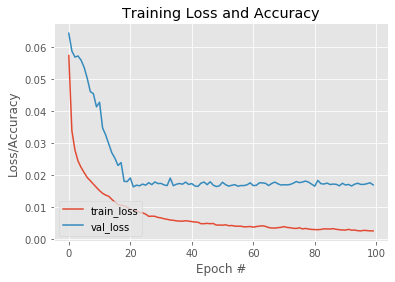

In [13]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [14]:
autoencoder.save(model_path)
autoencoder = tensorflow.keras.models.load_model(model_path, compile=False)

In [15]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

[INFO] making predictions...


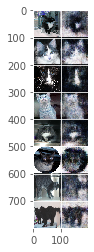

In [16]:
# loop over our number of output samples
for i in range(0, args["samples"]):
    # grab the original image and reconstructed image
    original = (testX[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

    # stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

    # if the outputs array is empty, initialize it as the current
    # side-by-side image display
    if outputs is None:
        outputs = output

    # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])

# save the outputs image to disk
cv2.imwrite(args["output"], outputs)

im = cv2.imread(args["output"])
img_RGB = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_list = np.asarray(img_RGB)
plt.imshow(im_list)
plt.show()